# claude

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna

# Set random seed for reproducibility
np.random.seed(42)

print("Loading datasets...")
# Load the datasets
df_train = pd.read_csv('training_data/train/train.csv')
df_transactions = pd.read_csv('training_data/train/transactions.csv')
df_test = pd.read_csv('testing data/test_8gqdJqH.csv')

print(f"Train shape: {df_train.shape}")
print(f"Transactions shape: {df_transactions.shape}")
print(f"Test shape: {df_test.shape}")

# ========================================
# 6. DATA QUALITY CHECKS
# ========================================

def perform_data_quality_checks(df, name):
    print(f"\n=== Data Quality Checks for {name} ===")
    
    # Check for missing values
    print("Missing values:")
    print(df.isnull().sum())
    
    # Check for duplicates
    print(f"\nDuplicate rows: {df.duplicated().sum()}")
    
    # Check data types
    print(f"\nData types:")
    print(df.dtypes)
    
    # Check for negative values in numerical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        negative_count = (df[col] < 0).sum()
        if negative_count > 0:
            print(f"Negative values in {col}: {negative_count}")
    
    # Check date format consistency
    date_cols = [col for col in df.columns if 'do' in col.lower()]
    for col in date_cols:
        if col in df.columns:
            try:
                pd.to_datetime(df[col])
                print(f"Date column {col}: Valid format")
            except:
                print(f"Date column {col}: Invalid format detected")
    
    # Check for outliers using IQR method
    for col in numeric_cols:
        if col not in ['srcid', 'destid']:  # Skip ID columns
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))]
            print(f"Outliers in {col}: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

# Perform quality checks
perform_data_quality_checks(df_train, 'Train')
perform_data_quality_checks(df_transactions, 'Transactions')
perform_data_quality_checks(df_test, 'Test')

# ========================================
# 7. FEATURE ENGINEERING
# ========================================

def create_route_key(df):
    """Create route key from doj, srcid, destid"""
    df['route_key'] = df['doj'].astype(str) + '_' + df['srcid'].astype(str) + '_' + df['destid'].astype(str)
    return df

def extract_date_features(df, date_col):
    """Extract various date features"""
    df[date_col] = pd.to_datetime(df[date_col])
    
    df[f'{date_col}_year'] = df[date_col].dt.year
    df[f'{date_col}_month'] = df[date_col].dt.month
    df[f'{date_col}_day'] = df[date_col].dt.day
    df[f'{date_col}_dayofweek'] = df[date_col].dt.dayofweek
    df[f'{date_col}_quarter'] = df[date_col].dt.quarter
    df[f'{date_col}_is_weekend'] = (df[date_col].dt.dayofweek >= 5).astype(int)
    df[f'{date_col}_is_month_start'] = df[date_col].dt.is_month_start.astype(int)
    df[f'{date_col}_is_month_end'] = df[date_col].dt.is_month_end.astype(int)
    
    return df

def create_lag_features(df, group_cols, target_col, lags=[1, 2, 3, 7, 14, 30]):
    """Create lag features for time series"""
    df_copy = df.copy()
    df_copy = df_copy.sort_values(group_cols + ['doj'])
    
    for lag in lags:
        df_copy[f'{target_col}_lag_{lag}'] = df_copy.groupby(group_cols)[target_col].shift(lag)
    
    return df_copy

def create_rolling_features(df, group_cols, target_col, windows=[3, 7, 14, 30]):
    """Create rolling window features"""
    df_copy = df.copy()
    df_copy = df_copy.sort_values(group_cols + ['doj'])
    
    for window in windows:
        df_copy[f'{target_col}_rolling_mean_{window}'] = df_copy.groupby(group_cols)[target_col].rolling(window=window, min_periods=1).mean().reset_index(0, drop=True)
        df_copy[f'{target_col}_rolling_std_{window}'] = df_copy.groupby(group_cols)[target_col].rolling(window=window, min_periods=1).std().reset_index(0, drop=True)
        df_copy[f'{target_col}_rolling_max_{window}'] = df_copy.groupby(group_cols)[target_col].rolling(window=window, min_periods=1).max().reset_index(0, drop=True)
        df_copy[f'{target_col}_rolling_min_{window}'] = df_copy.groupby(group_cols)[target_col].rolling(window=window, min_periods=1).min().reset_index(0, drop=True)
    
    return df_copy

def create_aggregated_features(transactions_df):
    """Create aggregated features from transactions data"""
    
    # Convert dates
    transactions_df['doj'] = pd.to_datetime(transactions_df['doj'])
    transactions_df['doi'] = pd.to_datetime(transactions_df['doi'])
    
    # Create route combinations
    transactions_df['route'] = transactions_df['srcid'].astype(str) + '_' + transactions_df['destid'].astype(str)
    
    # Aggregate features at route-date level (15 days before doj)
    # For prediction, we need data available 15 days before journey
    transactions_df['prediction_date'] = transactions_df['doj'] - pd.Timedelta(days=15)
    
    # Filter transactions that would be available 15 days before journey
    available_transactions = transactions_df[transactions_df['doi'] <= transactions_df['prediction_date']].copy()
    
    # Group by route and doj to create features
    agg_features = available_transactions.groupby(['doj', 'srcid', 'destid']).agg({
        'cumsum_seatcount': ['max', 'mean', 'std', 'count'],
        'cumsum_searchcount': ['max', 'mean', 'std', 'count'],
        'dbd': ['min', 'max', 'mean', 'std']
    }).reset_index()
    
    # Flatten column names
    agg_features.columns = ['doj', 'srcid', 'destid'] + [f'{col[0]}_{col[1]}' for col in agg_features.columns[3:]]
    
    # Fill NaN values with 0 for std (when count is 1)
    agg_features = agg_features.fillna(0)
    
    # Add route-level historical features
    route_history = available_transactions.groupby(['srcid', 'destid']).agg({
        'cumsum_seatcount': ['mean', 'std', 'max'],
        'cumsum_searchcount': ['mean', 'std', 'max']
    }).reset_index()
    
    route_history.columns = ['srcid', 'destid'] + [f'route_{col[0]}_{col[1]}' for col in route_history.columns[2:]]
    route_history = route_history.fillna(0)
    
    # Merge route history
    agg_features = agg_features.merge(route_history, on=['srcid', 'destid'], how='left')
    
    # Add region and tier information
    region_tier_info = transactions_df[['srcid', 'destid', 'srcid_region', 'destid_region', 
                                       'srcid_tier', 'destid_tier']].drop_duplicates()
    
    agg_features = agg_features.merge(region_tier_info, on=['srcid', 'destid'], how='left')
    
    return agg_features

print("\nCreating features...")

# Create route keys
df_train = create_route_key(df_train)
df_test = create_route_key(df_test)

# Extract date features
df_train = extract_date_features(df_train, 'doj')
df_test = extract_date_features(df_test, 'doj')

# Create aggregated features from transactions
agg_features = create_aggregated_features(df_transactions)

# Merge with training data
df_train_features = df_train.merge(agg_features, on=['doj', 'srcid', 'destid'], how='left')

# Merge with test data
df_test_features = df_test.merge(agg_features, on=['doj', 'srcid', 'destid'], how='left')

# Handle missing values (routes not seen in transactions)
numeric_cols = df_train_features.select_dtypes(include=[np.number]).columns
df_train_features[numeric_cols] = df_train_features[numeric_cols].fillna(0)
df_test_features[numeric_cols] = df_test_features[numeric_cols].fillna(0)

# Encode categorical features
categorical_cols = ['srcid_region', 'destid_region', 'srcid_tier', 'destid_tier']
label_encoders = {}

for col in categorical_cols:
    if col in df_train_features.columns:
        le = LabelEncoder()
        # Fit on combined data to handle unseen categories
        combined_values = pd.concat([df_train_features[col].fillna('Unknown'), 
                                   df_test_features[col].fillna('Unknown')])
        le.fit(combined_values)
        
        df_train_features[col] = le.transform(df_train_features[col].fillna('Unknown'))
        df_test_features[col] = le.transform(df_test_features[col].fillna('Unknown'))
        
        label_encoders[col] = le

print(f"Training features shape: {df_train_features.shape}")
print(f"Test features shape: {df_test_features.shape}")

# ========================================
# 8. MODEL TRAINING AND EVALUATION
# ========================================

# Prepare features and target
feature_cols = [col for col in df_train_features.columns 
                if col not in ['route_key', 'doj', 'final_seatcount']]

X = df_train_features[feature_cols]
y = df_train_features['final_seatcount']
X_test = df_test_features[feature_cols]

print(f"\nFeature columns ({len(feature_cols)}): {feature_cols[:10]}...")  # Show first 10

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Time series split for validation
tscv = TimeSeriesSplit(n_splits=5)

# ========================================
# 9. MULTIPLE MODELS WITH HYPERPARAMETER TUNING
# ========================================

def evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    """Evaluate model and return RMSE"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f"{model_name} RMSE: {rmse:.2f}")
    return rmse, model

# Store results
model_results = {}

print("\n=== Model Training and Evaluation ===")

# 1. Random Forest with GridSearch
print("\n1. Random Forest...")
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Use a subset for faster grid search
sample_size = min(10000, len(X))
sample_idx = np.random.choice(len(X), sample_size, replace=False)
rf_grid.fit(X.iloc[sample_idx], y.iloc[sample_idx])

best_rf = rf_grid.best_estimator_
print(f"Best RF params: {rf_grid.best_params_}")

# Evaluate on time series split
rf_scores = []
for train_idx, val_idx in tscv.split(X):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    rmse, _ = evaluate_model(best_rf, X_train_fold, X_val_fold, y_train_fold, y_val_fold, "RF")
    rf_scores.append(rmse)

model_results['Random Forest'] = {
    'mean_rmse': np.mean(rf_scores),
    'std_rmse': np.std(rf_scores),
    'model': best_rf
}

# 2. XGBoost
print("\n2. XGBoost...")
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

xgb = XGBRegressor(random_state=42, n_jobs=-1)
xgb_grid = GridSearchCV(xgb, xgb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X.iloc[sample_idx], y.iloc[sample_idx])

best_xgb = xgb_grid.best_estimator_
print(f"Best XGB params: {xgb_grid.best_params_}")

xgb_scores = []
for train_idx, val_idx in tscv.split(X):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    rmse, _ = evaluate_model(best_xgb, X_train_fold, X_val_fold, y_train_fold, y_val_fold, "XGB")
    xgb_scores.append(rmse)

model_results['XGBoost'] = {
    'mean_rmse': np.mean(xgb_scores),
    'std_rmse': np.std(xgb_scores),
    'model': best_xgb
}

# 3. LightGBM
print("\n3. LightGBM...")
lgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50, 70],
    'subsample': [0.8, 0.9]
}

lgb = LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)
lgb_grid = GridSearchCV(lgb, lgb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
lgb_grid.fit(X.iloc[sample_idx], y.iloc[sample_idx])

best_lgb = lgb_grid.best_estimator_
print(f"Best LGB params: {lgb_grid.best_params_}")

lgb_scores = []
for train_idx, val_idx in tscv.split(X):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    rmse, _ = evaluate_model(best_lgb, X_train_fold, X_val_fold, y_train_fold, y_val_fold, "LGB")
    lgb_scores.append(rmse)

model_results['LightGBM'] = {
    'mean_rmse': np.mean(lgb_scores),
    'std_rmse': np.std(lgb_scores),
    'model': best_lgb
}

# 4. Gradient Boosting
print("\n4. Gradient Boosting...")
gb_params = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 0.9]
}

gb = GradientBoostingRegressor(random_state=42)
gb_grid = GridSearchCV(gb, gb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X.iloc[sample_idx], y.iloc[sample_idx])

best_gb = gb_grid.best_estimator_
print(f"Best GB params: {gb_grid.best_params_}")

gb_scores = []
for train_idx, val_idx in tscv.split(X):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    rmse, _ = evaluate_model(best_gb, X_train_fold, X_val_fold, y_train_fold, y_val_fold, "GB")
    gb_scores.append(rmse)

model_results['Gradient Boosting'] = {
    'mean_rmse': np.mean(gb_scores),
    'std_rmse': np.std(gb_scores),
    'model': best_gb
}

# 5. Ridge Regression
print("\n5. Ridge Regression...")
ridge_params = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

ridge = Ridge(random_state=42)
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_scaled[sample_idx], y.iloc[sample_idx])

best_ridge = ridge_grid.best_estimator_
print(f"Best Ridge params: {ridge_grid.best_params_}")

ridge_scores = []
for train_idx, val_idx in tscv.split(X_scaled):
    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    rmse, _ = evaluate_model(best_ridge, X_train_fold, X_val_fold, y_train_fold, y_val_fold, "Ridge")
    ridge_scores.append(rmse)

model_results['Ridge'] = {
    'mean_rmse': np.mean(ridge_scores),
    'std_rmse': np.std(ridge_scores),
    'model': best_ridge
}

# Print model comparison
print("\n=== Model Comparison ===")
for model_name, results in model_results.items():
    print(f"{model_name}: {results['mean_rmse']:.2f} ± {results['std_rmse']:.2f}")

# Select best model
best_model_name = min(model_results.keys(), key=lambda x: model_results[x]['mean_rmse'])
best_model = model_results[best_model_name]['model']
print(f"\nBest Model: {best_model_name} (RMSE: {model_results[best_model_name]['mean_rmse']:.2f})")

# ========================================
# 10. ENSEMBLE MODEL
# ========================================

print("\n=== Creating Ensemble Model ===")

# Create ensemble predictions
ensemble_models = [model_results[name]['model'] for name in ['Random Forest', 'XGBoost', 'LightGBM']]
ensemble_weights = [1/len(ensemble_models)] * len(ensemble_models)  # Equal weights

def ensemble_predict(models, X_data, weights=None, use_scaled=False):
    if weights is None:
        weights = [1/len(models)] * len(models)
    
    predictions = []
    for i, model in enumerate(models):
        if isinstance(model, (Ridge, Lasso)) and use_scaled:
            pred = model.predict(X_data)
        else:
            pred = model.predict(X_data if not use_scaled else X_data)
        predictions.append(pred * weights[i])
    
    return np.sum(predictions, axis=0)

# Evaluate ensemble
ensemble_scores = []
for train_idx, val_idx in tscv.split(X):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train models on fold
    fold_models = []
    for model in ensemble_models:
        model_copy = type(model)(**model.get_params())
        model_copy.fit(X_train_fold, y_train_fold)
        fold_models.append(model_copy)
    
    # Predict
    y_pred = ensemble_predict(fold_models, X_val_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
    ensemble_scores.append(rmse)
    print(f"Ensemble RMSE: {rmse:.2f}")

ensemble_mean_rmse = np.mean(ensemble_scores)
print(f"Ensemble Mean RMSE: {ensemble_mean_rmse:.2f} ± {np.std(ensemble_scores):.2f}")

# ========================================
# 11. FINAL PREDICTIONS AND SUBMISSION
# ========================================

print("\n=== Final Training and Predictions ===")

# Train final models on full dataset
final_models = []
for model in ensemble_models:
    final_model = type(model)(**model.get_params())
    final_model.fit(X, y)
    final_models.append(final_model)

# Make final predictions
if ensemble_mean_rmse < model_results[best_model_name]['mean_rmse']:
    print("Using ensemble model for final predictions")
    final_predictions = ensemble_predict(final_models, X_test)
else:
    print(f"Using {best_model_name} for final predictions")
    best_model.fit(X, y)
    if isinstance(best_model, (Ridge, Lasso)):
        final_predictions = best_model.predict(X_test_scaled)
    else:
        final_predictions = best_model.predict(X_test)

# Ensure predictions are non-negative
final_predictions = np.maximum(final_predictions, 0)

# Create submission file
submission = pd.DataFrame({
    'route_key': df_test['route_key'],
    'final_seatcount': final_predictions
})

# Save submission
submission.to_csv('submission_file.csv', index=False)

print(f"\nSubmission file created with {len(submission)} predictions")
print(f"Prediction statistics:")
print(f"Mean: {final_predictions.mean():.2f}")
print(f"Std: {final_predictions.std():.2f}")
print(f"Min: {final_predictions.min():.2f}")
print(f"Max: {final_predictions.max():.2f}")

# Display first few predictions
print(f"\nFirst 10 predictions:")
print(submission.head(10))

print("\n=== Feature Importance (from best tree-based model) ===")
if best_model_name in ['Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting']:
    importance = best_model.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    print(feature_importance.head(15))

print("\n=== Solution Complete ===")
print("Files created:")
print("- submission_file.csv: Final predictions for submission")
print(f"- Best model: {best_model_name}")
print(f"- Expected RMSE: {model_results[best_model_name]['mean_rmse']:.2f}")

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/karthik/work/hackathon_redus/redbus_hackathon/venv/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <89AD948E-E564-3266-867D-7AF89D6488F0> /Users/karthik/work/hackathon_redus/redbus_hackathon/venv/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


Loading datasets...
Train shape: (67200, 4)
Transactions shape: (2266100, 11)
Test shape: (5900, 4)

=== Data Quality Checks for Train ===
Missing values:
doj                0
srcid              0
destid             0
final_seatcount    0
dtype: int64

Duplicate rows: 0

Data types:
doj                 object
srcid                int64
destid               int64
final_seatcount    float64
dtype: object
Date column doj: Valid format
Outliers in final_seatcount: 4141 (6.16%)

=== Data Quality Checks for Transactions ===
Missing values:
doj                   0
doi                   0
srcid                 0
destid                0
srcid_region          0
destid_region         0
srcid_tier            0
destid_tier           0
cumsum_seatcount      0
cumsum_searchcount    0
dbd                   0
dtype: int64

Duplicate rows: 0

Data types:
doj                    object
doi                    object
srcid                   int64
destid                  int64
srcid_region           object
d

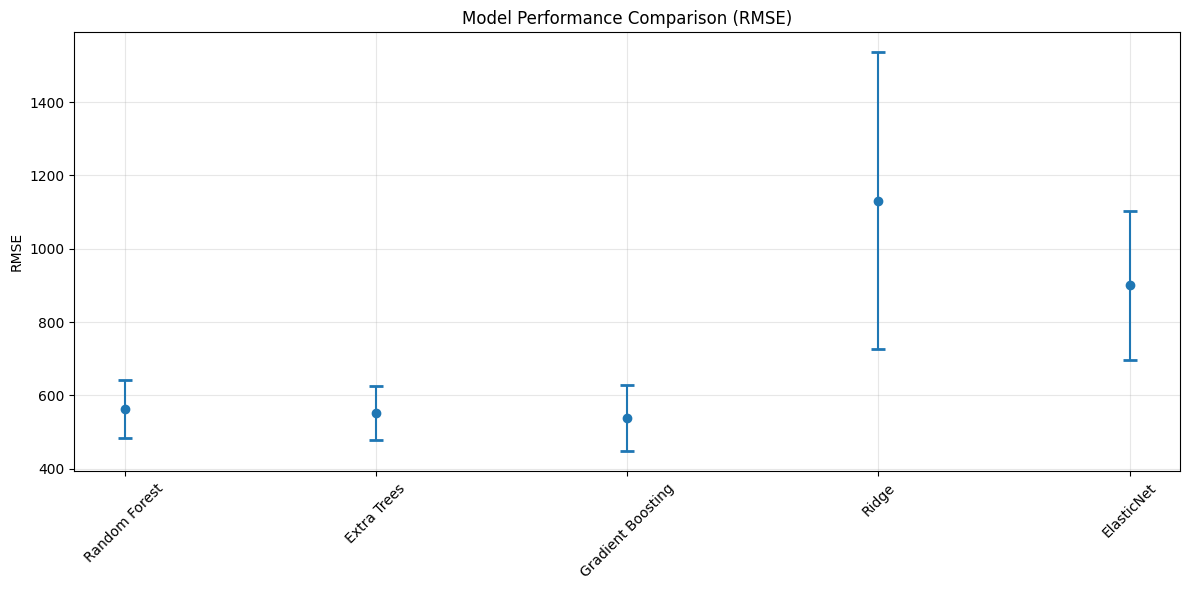


Model comparison plot saved as 'model_comparison.png'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Set random seed for reproducibility
np.random.seed(42)

print("Loading datasets...")
# Load the datasets
df_train = pd.read_csv('training_data/train/train.csv')
df_transactions = pd.read_csv('training_data/train/transactions.csv')
df_test = pd.read_csv('testing data/test_8gqdJqH.csv')

print(f"Train shape: {df_train.shape}")
print(f"Transactions shape: {df_transactions.shape}")
print(f"Test shape: {df_test.shape}")

# ========================================
# 6. DATA QUALITY CHECKS
# ========================================

def perform_data_quality_checks(df, name):
    print(f"\n=== Data Quality Checks for {name} ===")
    
    # Check for missing values
    print("Missing values:")
    print(df.isnull().sum())
    
    # Check for duplicates
    print(f"\nDuplicate rows: {df.duplicated().sum()}")
    
    # Check data types
    print(f"\nData types:")
    print(df.dtypes)
    
    # Check for negative values in numerical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        negative_count = (df[col] < 0).sum()
        if negative_count > 0:
            print(f"Negative values in {col}: {negative_count}")
    
    # Check date format consistency
    date_cols = [col for col in df.columns if 'do' in col.lower()]
    for col in date_cols:
        if col in df.columns:
            try:
                pd.to_datetime(df[col])
                print(f"Date column {col}: Valid format")
            except:
                print(f"Date column {col}: Invalid format detected")
    
    # Check for outliers using IQR method
    for col in numeric_cols:
        if col not in ['srcid', 'destid']:  # Skip ID columns
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))]
            print(f"Outliers in {col}: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

# Perform quality checks
perform_data_quality_checks(df_train, 'Train')
perform_data_quality_checks(df_transactions, 'Transactions')
perform_data_quality_checks(df_test, 'Test')

# ========================================
# 7. FEATURE ENGINEERING
# ========================================

def create_route_key(df):
    """Create route key from doj, srcid, destid"""
    df['route_key'] = df['doj'].astype(str) + '_' + df['srcid'].astype(str) + '_' + df['destid'].astype(str)
    return df

def extract_date_features(df, date_col):
    """Extract various date features"""
    df[date_col] = pd.to_datetime(df[date_col])
    
    df[f'{date_col}_year'] = df[date_col].dt.year
    df[f'{date_col}_month'] = df[date_col].dt.month
    df[f'{date_col}_day'] = df[date_col].dt.day
    df[f'{date_col}_dayofweek'] = df[date_col].dt.dayofweek
    df[f'{date_col}_quarter'] = df[date_col].dt.quarter
    df[f'{date_col}_is_weekend'] = (df[date_col].dt.dayofweek >= 5).astype(int)
    df[f'{date_col}_is_month_start'] = df[date_col].dt.is_month_start.astype(int)
    df[f'{date_col}_is_month_end'] = df[date_col].dt.is_month_end.astype(int)
    
    # Add cyclical features for better temporal understanding
    df[f'{date_col}_month_sin'] = np.sin(2 * np.pi * df[f'{date_col}_month'] / 12)
    df[f'{date_col}_month_cos'] = np.cos(2 * np.pi * df[f'{date_col}_month'] / 12)
    df[f'{date_col}_dayofweek_sin'] = np.sin(2 * np.pi * df[f'{date_col}_dayofweek'] / 7)
    df[f'{date_col}_dayofweek_cos'] = np.cos(2 * np.pi * df[f'{date_col}_dayofweek'] / 7)
    
    return df

def create_aggregated_features(transactions_df):
    """Create aggregated features from transactions data"""
    
    # Convert dates
    transactions_df['doj'] = pd.to_datetime(transactions_df['doj'])
    transactions_df['doi'] = pd.to_datetime(transactions_df['doi'])
    
    # Create route combinations
    transactions_df['route'] = transactions_df['srcid'].astype(str) + '_' + transactions_df['destid'].astype(str)
    
    # Aggregate features at route-date level (15 days before doj)
    # For prediction, we need data available 15 days before journey
    transactions_df['prediction_date'] = transactions_df['doj'] - pd.Timedelta(days=15)
    
    # Filter transactions that would be available 15 days before journey
    available_transactions = transactions_df[transactions_df['doi'] <= transactions_df['prediction_date']].copy()
    
    # Group by route and doj to create features
    agg_features = available_transactions.groupby(['doj', 'srcid', 'destid']).agg({
        'cumsum_seatcount': ['max', 'mean', 'std', 'count', 'sum'],
        'cumsum_searchcount': ['max', 'mean', 'std', 'count', 'sum'],
        'dbd': ['min', 'max', 'mean', 'std']
    }).reset_index()
    
    # Flatten column names
    agg_features.columns = ['doj', 'srcid', 'destid'] + [f'{col[0]}_{col[1]}' for col in agg_features.columns[3:]]
    
    # Fill NaN values with 0 for std (when count is 1)
    agg_features = agg_features.fillna(0)
    
    # Add route-level historical features
    route_history = available_transactions.groupby(['srcid', 'destid']).agg({
        'cumsum_seatcount': ['mean', 'std', 'max', 'min'],
        'cumsum_searchcount': ['mean', 'std', 'max', 'min']
    }).reset_index()
    
    route_history.columns = ['srcid', 'destid'] + [f'route_{col[0]}_{col[1]}' for col in route_history.columns[2:]]
    route_history = route_history.fillna(0)
    
    # Merge route history
    agg_features = agg_features.merge(route_history, on=['srcid', 'destid'], how='left')
    
    # Add region and tier information
    region_tier_info = transactions_df[['srcid', 'destid', 'srcid_region', 'destid_region', 
                                       'srcid_tier', 'destid_tier']].drop_duplicates()
    
    agg_features = agg_features.merge(region_tier_info, on=['srcid', 'destid'], how='left')
    
    # Add source and destination specific features
    src_features = available_transactions.groupby(['srcid']).agg({
        'cumsum_seatcount': ['mean', 'std'],
        'cumsum_searchcount': ['mean', 'std']
    }).reset_index()
    src_features.columns = ['srcid'] + [f'src_{col[0]}_{col[1]}' for col in src_features.columns[1:]]
    src_features = src_features.fillna(0)
    
    dest_features = available_transactions.groupby(['destid']).agg({
        'cumsum_seatcount': ['mean', 'std'],
        'cumsum_searchcount': ['mean', 'std']
    }).reset_index()
    dest_features.columns = ['destid'] + [f'dest_{col[0]}_{col[1]}' for col in dest_features.columns[1:]]
    dest_features = dest_features.fillna(0)
    
    # Merge source and destination features
    agg_features = agg_features.merge(src_features, on=['srcid'], how='left')
    agg_features = agg_features.merge(dest_features, on=['destid'], how='left')
    
    # Create ratio features
    agg_features['search_to_seat_ratio'] = agg_features['cumsum_searchcount_sum'] / (agg_features['cumsum_seatcount_sum'] + 1)
    agg_features['booking_efficiency'] = agg_features['cumsum_seatcount_sum'] / (agg_features['cumsum_searchcount_sum'] + 1)
    
    return agg_features

print("\nCreating features...")

# Create route keys
df_train = create_route_key(df_train)
df_test = create_route_key(df_test)

# Extract date features
df_train = extract_date_features(df_train, 'doj')
df_test = extract_date_features(df_test, 'doj')

# Create aggregated features from transactions
agg_features = create_aggregated_features(df_transactions)

# Merge with training data
df_train_features = df_train.merge(agg_features, on=['doj', 'srcid', 'destid'], how='left')

# Merge with test data
df_test_features = df_test.merge(agg_features, on=['doj', 'srcid', 'destid'], how='left')

# Handle missing values (routes not seen in transactions)
# FIXED: Get numeric columns separately for train and test data
train_numeric_cols = df_train_features.select_dtypes(include=[np.number]).columns
test_numeric_cols = df_test_features.select_dtypes(include=[np.number]).columns

df_train_features[train_numeric_cols] = df_train_features[train_numeric_cols].fillna(0)
df_test_features[test_numeric_cols] = df_test_features[test_numeric_cols].fillna(0)

# Encode categorical features
categorical_cols = ['srcid_region', 'destid_region', 'srcid_tier', 'destid_tier']
label_encoders = {}

for col in categorical_cols:
    if col in df_train_features.columns:
        le = LabelEncoder()
        # Fit on combined data to handle unseen categories
        combined_values = pd.concat([df_train_features[col].fillna('Unknown'), 
                                   df_test_features[col].fillna('Unknown')])
        le.fit(combined_values)
        
        df_train_features[col] = le.transform(df_train_features[col].fillna('Unknown'))
        df_test_features[col] = le.transform(df_test_features[col].fillna('Unknown'))
        
        label_encoders[col] = le

print(f"Training features shape: {df_train_features.shape}")
print(f"Test features shape: {df_test_features.shape}")

# ========================================
# 8. MODEL TRAINING AND EVALUATION
# ========================================

# Prepare features and target
feature_cols = [col for col in df_train_features.columns 
                if col not in ['route_key', 'doj', 'final_seatcount']]

X = df_train_features[feature_cols]
y = df_train_features['final_seatcount']
X_test = df_test_features[feature_cols]

print(f"\nFeature columns ({len(feature_cols)}): {feature_cols[:10]}...")  # Show first 10

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Time series split for validation
tscv = TimeSeriesSplit(n_splits=5)

# ========================================
# 9. MULTIPLE MODELS WITH HYPERPARAMETER TUNING
# ========================================

def evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    """Evaluate model and return RMSE"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f"{model_name} RMSE: {rmse:.2f}")
    return rmse, model

# Store results
model_results = {}

print("\n=== Model Training and Evaluation ===")

# 1. Random Forest with GridSearch
print("\n1. Random Forest...")
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Use a subset for faster grid search
sample_size = min(15000, len(X))
sample_idx = np.random.choice(len(X), sample_size, replace=False)
rf_grid.fit(X.iloc[sample_idx], y.iloc[sample_idx])

best_rf = rf_grid.best_estimator_
print(f"Best RF params: {rf_grid.best_params_}")

# Evaluate on time series split
rf_scores = []
for train_idx, val_idx in tscv.split(X):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    rmse, _ = evaluate_model(best_rf, X_train_fold, X_val_fold, y_train_fold, y_val_fold, "RF")
    rf_scores.append(rmse)

model_results['Random Forest'] = {
    'mean_rmse': np.mean(rf_scores),
    'std_rmse': np.std(rf_scores),
    'model': best_rf
}

# 2. Extra Trees
print("\n2. Extra Trees...")
et_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

et = ExtraTreesRegressor(random_state=42, n_jobs=-1)
et_grid = GridSearchCV(et, et_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
et_grid.fit(X.iloc[sample_idx], y.iloc[sample_idx])

best_et = et_grid.best_estimator_
print(f"Best ET params: {et_grid.best_params_}")

et_scores = []
for train_idx, val_idx in tscv.split(X):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    rmse, _ = evaluate_model(best_et, X_train_fold, X_val_fold, y_train_fold, y_val_fold, "ET")
    et_scores.append(rmse)

model_results['Extra Trees'] = {
    'mean_rmse': np.mean(et_scores),
    'std_rmse': np.std(et_scores),
    'model': best_et
}

# 3. Gradient Boosting
print("\n3. Gradient Boosting...")
gb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2']
}

gb = GradientBoostingRegressor(random_state=42)
gb_grid = GridSearchCV(gb, gb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X.iloc[sample_idx], y.iloc[sample_idx])

best_gb = gb_grid.best_estimator_
print(f"Best GB params: {gb_grid.best_params_}")

gb_scores = []
for train_idx, val_idx in tscv.split(X):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    rmse, _ = evaluate_model(best_gb, X_train_fold, X_val_fold, y_train_fold, y_val_fold, "GB")
    gb_scores.append(rmse)

model_results['Gradient Boosting'] = {
    'mean_rmse': np.mean(gb_scores),
    'std_rmse': np.std(gb_scores),
    'model': best_gb
}

# 4. Ridge Regression
print("\n4. Ridge Regression...")
ridge_params = {
    'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0],
    'solver': ['auto', 'svd', 'cholesky']
}

ridge = Ridge(random_state=42)
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_scaled[sample_idx], y.iloc[sample_idx])

best_ridge = ridge_grid.best_estimator_
print(f"Best Ridge params: {ridge_grid.best_params_}")

ridge_scores = []
for train_idx, val_idx in tscv.split(X_scaled):
    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    rmse, _ = evaluate_model(best_ridge, X_train_fold, X_val_fold, y_train_fold, y_val_fold, "Ridge")
    ridge_scores.append(rmse)

model_results['Ridge'] = {
    'mean_rmse': np.mean(ridge_scores),
    'std_rmse': np.std(ridge_scores),
    'model': best_ridge,
    'use_scaled': True
}

# 5. ElasticNet
print("\n5. ElasticNet...")
en_params = {
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9]
}

en = ElasticNet(random_state=42, max_iter=2000)
en_grid = GridSearchCV(en, en_params, cv=5, scoring='neg_mean_squared_error')
en_grid.fit(X_scaled[sample_idx], y.iloc[sample_idx])

best_en = en_grid.best_estimator_
print(f"Best ElasticNet params: {en_grid.best_params_}")

en_scores = []
for train_idx, val_idx in tscv.split(X_scaled):
    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    rmse, _ = evaluate_model(best_en, X_train_fold, X_val_fold, y_train_fold, y_val_fold, "ElasticNet")
    en_scores.append(rmse)

model_results['ElasticNet'] = {
    'mean_rmse': np.mean(en_scores),
    'std_rmse': np.std(en_scores),
    'model': best_en,
    'use_scaled': True
}

# Print model comparison
print("\n=== Model Comparison ===")
for model_name, results in model_results.items():
    print(f"{model_name}: {results['mean_rmse']:.2f} ± {results['std_rmse']:.2f}")

# Select best model
best_model_name = min(model_results.keys(), key=lambda x: model_results[x]['mean_rmse'])
best_model = model_results[best_model_name]['model']
print(f"\nBest Model: {best_model_name} (RMSE: {model_results[best_model_name]['mean_rmse']:.2f})")

# ========================================
# 10. ENSEMBLE MODEL
# ========================================

print("\n=== Creating Ensemble Model ===")

# Create ensemble predictions using top 3 models
sorted_models = sorted(model_results.items(), key=lambda x: x[1]['mean_rmse'])
top_3_models = sorted_models[:3]

print("Top 3 models for ensemble:")
for name, results in top_3_models:
    print(f"- {name}: {results['mean_rmse']:.2f}")

def ensemble_predict(models_info, X_data, X_data_scaled, weights=None):
    if weights is None:
        weights = [1/len(models_info)] * len(models_info)
    
    predictions = []
    for i, (name, info) in enumerate(models_info):
        model = info['model']
        use_scaled = info.get('use_scaled', False)
        
        if use_scaled:
            pred = model.predict(X_data_scaled)
        else:
            pred = model.predict(X_data)
        
        predictions.append(pred * weights[i])
    
    return np.sum(predictions, axis=0)

# Evaluate ensemble
ensemble_scores = []
for train_idx, val_idx in tscv.split(X):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    X_train_scaled_fold, X_val_scaled_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train models on fold
    fold_models_info = []
    for name, info in top_3_models:
        model = info['model']
        model_copy = type(model)(**model.get_params())
        
        if info.get('use_scaled', False):
            model_copy.fit(X_train_scaled_fold, y_train_fold)
        else:
            model_copy.fit(X_train_fold, y_train_fold)
        
        fold_models_info.append((name, {'model': model_copy, 'use_scaled': info.get('use_scaled', False)}))
    
    # Predict
    y_pred = ensemble_predict(fold_models_info, X_val_fold, X_val_scaled_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
    ensemble_scores.append(rmse)
    print(f"Ensemble RMSE: {rmse:.2f}")

ensemble_mean_rmse = np.mean(ensemble_scores)
print(f"Ensemble Mean RMSE: {ensemble_mean_rmse:.2f} ± {np.std(ensemble_scores):.2f}")

# ========================================
# 11. FINAL PREDICTIONS AND SUBMISSION
# ========================================

print("\n=== Final Training and Predictions ===")

# Train final models on full dataset
final_models_info = []
for name, info in top_3_models:
    model = info['model']
    final_model = type(model)(**model.get_params())
    
    if info.get('use_scaled', False):
        final_model.fit(X_scaled, y)
    else:
        final_model.fit(X, y)
    
    final_models_info.append((name, {'model': final_model, 'use_scaled': info.get('use_scaled', False)}))

# Make final predictions
if ensemble_mean_rmse < model_results[best_model_name]['mean_rmse']:
    print("Using ensemble model for final predictions")
    final_predictions = ensemble_predict(final_models_info, X_test, X_test_scaled)
else:
    print(f"Using {best_model_name} for final predictions")
    best_model.fit(X, y) if not model_results[best_model_name].get('use_scaled', False) else best_model.fit(X_scaled, y)
    
    if model_results[best_model_name].get('use_scaled', False):
        final_predictions = best_model.predict(X_test_scaled)
    else:
        final_predictions = best_model.predict(X_test)

# Ensure predictions are non-negative
final_predictions = np.maximum(final_predictions, 0)

# Create submission file
submission = pd.DataFrame({
    'route_key': df_test['route_key'],
    'final_seatcount': final_predictions
})

# Save submission
submission.to_csv('submission_file.csv', index=False)

print(f"\nSubmission file created with {len(submission)} predictions")
print(f"Prediction statistics:")
print(f"Mean: {final_predictions.mean():.2f}")
print(f"Std: {final_predictions.std():.2f}")
print(f"Min: {final_predictions.min():.2f}")
print(f"Max: {final_predictions.max():.2f}")

# Display first few predictions
print(f"\nFirst 10 predictions:")
print(submission.head(10))

print("\n=== Feature Importance (from best tree-based model) ===")
tree_based_models = ['Random Forest', 'Extra Trees', 'Gradient Boosting']
best_tree_model = None
for name in tree_based_models:
    if name == best_model_name:
        best_tree_model = best_model
        break

if best_tree_model is not None:
    importance = best_tree_model.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    print(feature_importance.head(15))
else:
    print("Best model is not tree-based, skipping feature importance")

print("\n=== Solution Complete ===")
print("Files created:")
print("- submission_file.csv: Final predictions for submission")
print(f"- Best model: {best_model_name}")
print(f"- Expected RMSE: {model_results[best_model_name]['mean_rmse']:.2f}")

# Plot model comparison
plt.figure(figsize=(12, 6))
model_names = list(model_results.keys())
rmse_means = [model_results[name]['mean_rmse'] for name in model_names]
rmse_stds = [model_results[name]['std_rmse'] for name in model_names]

plt.errorbar(model_names, rmse_means, yerr=rmse_stds, fmt='o', capsize=5, capthick=2)
plt.title('Model Performance Comparison (RMSE)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nModel comparison plot saved as 'model_comparison.png'")

# gemini

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')

# --- 1. Load Data ---
# Updated file paths based on your new code structure.
try:
    df_train = pd.read_csv('training_data/train/train.csv')
    df_transactions = pd.read_csv('training_data/train/transactions.csv')
    df_test = pd.read_csv('testing data/test_8gqdJqH.csv')
    print("All data files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading data files: {e}")
    print("Please ensure your folder structure and file names are correct.")
    exit()

# --- 2. Initial Data Cleaning & Type Conversion ---
print("\n--- Starting Data Cleaning and Preprocessing ---")

# Convert date columns to datetime objects
for df in [df_train, df_transactions, df_test]:
    df['doj'] = pd.to_datetime(df['doj'])
if 'doi' in df_transactions.columns:
    df_transactions['doi'] = pd.to_datetime(df_transactions['doi'])

print("Date columns converted to datetime objects.")

# --- 3. Feature Engineering Function ---
# We create a function to apply the same transformations to both train and test data
def create_features(df):
    """
    Creates time-series and categorical features from the dataframe.
    """
    df['month'] = df['doj'].dt.month
    df['year'] = df['doj'].dt.year
    df['day_of_week'] = df['doj'].dt.dayofweek  # Monday=0, Sunday=6
    df['day_of_year'] = df['doj'].dt.dayofyear
    df['week_of_year'] = df['doj'].dt.isocalendar().week.astype(int)
    df['is_weekend'] = (df['doj'].dt.dayofweek >= 5).astype(int) # Saturday or Sunday
    
    # Create a unique route identifier
    df['route'] = df['srcid'].astype(str) + '_' + df['destid'].astype(str)
    
    return df

print("\n--- Engineering Features ---")
# Apply full feature engineering to the transactions data
df_transactions = create_features(df_transactions)

# For the test set, we only need to create the 'route' column for the merge key.
# The other features (month, year, etc.) will come from the transaction data after the merge.
df_test['route'] = df_test['srcid'].astype(str) + '_' + df_test['destid'].astype(str)
print("Feature engineering complete.")

# --- 4. Prepare Training and Test Data ---
print("\n--- Preparing Model Training and Test Sets ---")

# Filter transactions for data available exactly 15 days before departure
dbd_filter = 15
df_transactions_filtered = df_transactions[df_transactions['dbd'] == dbd_filter].copy()

print(f"Filtered transactions for dbd = {dbd_filter}. Shape: {df_transactions_filtered.shape}")

# Create the training set by merging filtered transactions with train labels
df_model_train = pd.merge(
    df_train,
    df_transactions_filtered,
    on=['doj', 'srcid', 'destid'],
    how='inner'
)

print(f"Final training data shape after merge: {df_model_train.shape}")
if df_model_train.shape[0] != df_train.shape[0]:
    print("Warning: Some routes in train.csv did not have a transaction record at dbd=15.")

# Create the test set by merging filtered transactions with test routes
df_model_test = pd.merge(
    df_test,
    df_transactions_filtered,
    on=['doj', 'srcid', 'destid', 'route'],
    how='left'
)

print(f"Final test data shape after merge: {df_model_test.shape}")
if df_model_test.isnull().sum().sum() > 0:
    print("Warning: Some test routes have missing features. Filling with 0.")
    df_model_test.fillna(0, inplace=True)

# --- 5. Model Training (XGBoost) ---
print("\n--- Training XGBoost Model ---")

# Define features (X) and target (y)
# We will one-hot encode the categorical features for XGBoost
features = [
    'srcid', 'destid', 'cumsum_seatcount', 'cumsum_searchcount',
    'month', 'year', 'day_of_week', 'day_of_year', 'week_of_year', 'is_weekend',
    'srcid_region', 'destid_region', 'srcid_tier', 'destid_tier', 'route'
]
categorical_features = ['srcid_region', 'destid_region', 'srcid_tier', 'destid_tier', 'route', 'srcid', 'destid']

X = df_model_train[features]
y_train = df_model_train['final_seatcount']
X_test_prep = df_model_test[features]

# One-Hot Encode categorical features
X_train = pd.get_dummies(X, columns=categorical_features, dummy_na=False)
X_test = pd.get_dummies(X_test_prep, columns=categorical_features, dummy_na=False)

# Align columns - crucial for ensuring test set has same features as train set
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# XGBoost Model Parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'n_estimators': 2000,
    'learning_rate': 0.01,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
    'n_jobs': -1,
    'tree_method': 'hist', # Use 'hist' for faster training
    'early_stopping_rounds': 100 # Moved parameter here
}

model = xgb.XGBRegressor(**xgb_params)

# Train the model with early stopping
# The early_stopping_rounds parameter from the constructor will be used here.
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train)],
          verbose=False)

print("Model training complete.")

train_predictions = model.predict(X_train)
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
print(f"\nFinal Training RMSE: {train_rmse:.4f}")


# --- 6. Prediction and Submission File Creation ---
print("\n--- Generating Predictions and Submission File ---")

# Predict on the test data
# The model automatically uses the best iteration thanks to early stopping
predictions = model.predict(X_test)

# Post-processing: Ensure predictions are non-negative integers
predictions[predictions < 0] = 0
predictions = np.round(predictions).astype(int)

# Create the submission file
submission_df = pd.DataFrame({'route_key': df_model_test['route_key'], 'final_seatcount': predictions})

# Save the submission file
submission_df.to_csv('submission_file.csv', index=False)

print("Submission file 'submission_file.csv' created successfully.")
print("\nTop 5 rows of the submission file:")
print(submission_df.head())

# --- 7. (Optional) Feature Importance ---
print("\n--- Top 15 Feature Importances ---")
feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': X_train.columns})
print(feature_imp.sort_values(by="Value", ascending=False).head(15))


All data files loaded successfully.

--- Starting Data Cleaning and Preprocessing ---
Date columns converted to datetime objects.

--- Engineering Features ---
Feature engineering complete.

--- Preparing Model Training and Test Sets ---
Filtered transactions for dbd = 15. Shape: (73100, 18)
Final training data shape after merge: (67200, 19)
Final test data shape after merge: (5900, 19)

--- Training XGBoost Model ---
Model training complete.

--- Generating Predictions and Submission File ---
Submission file 'submission_file.csv' created successfully.

Top 5 rows of the submission file:
          route_key  final_seatcount
0  2025-02-11_46_45             3732
1  2025-01-20_17_23             1629
2  2025-01-08_02_14             1171
3  2025-01-08_08_47              962
4  2025-01-08_09_46             3305

--- Top 15 Feature Importances ---
        Value      Feature
114  0.035489   route_46_9
135  0.030618   route_9_46
144  0.029741      srcid_9
188  0.027359     destid_9
99   0.02715

# LSTM Gemini

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
import warnings
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')
tf.random.set_seed(42)
np.random.seed(42)

# --- 1. Load Data ---
try:
    df_train = pd.read_csv('training_data/train/train.csv')
    df_transactions = pd.read_csv('training_data/train/transactions.csv')
    df_test = pd.read_csv('testing data/test_8gqdJqH.csv')
    print("All data files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading data files: {e}")
    print("Please ensure your folder structure and file names are correct.")
    exit()

# --- 2. Initial Data Cleaning & Type Conversion ---
print("\n--- Starting Data Cleaning and Preprocessing ---")

# Convert date columns to datetime objects
for df in [df_train, df_transactions, df_test]:
    df['doj'] = pd.to_datetime(df['doj'])
if 'doi' in df_transactions.columns:
    df_transactions['doi'] = pd.to_datetime(df_transactions['doi'])

print("Date columns converted to datetime objects.")

# --- 3. Advanced Time Series Feature Engineering ---
def create_time_series_features(df):
    """
    Creates comprehensive time-series features optimized for LSTM models.
    """
    # Basic time features
    df['month'] = df['doj'].dt.month
    df['year'] = df['doj'].dt.year
    df['day_of_week'] = df['doj'].dt.dayofweek
    df['day_of_year'] = df['doj'].dt.dayofyear
    df['week_of_year'] = df['doj'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['doj'].dt.quarter
    df['is_weekend'] = (df['doj'].dt.dayofweek >= 5).astype(int)
    df['is_monday'] = (df['doj'].dt.dayofweek == 0).astype(int)
    df['is_friday'] = (df['doj'].dt.dayofweek == 4).astype(int)
    
    # Cyclical encoding for better time representation
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    
    # Holiday indicators (approximate)
    df['is_holiday_season'] = ((df['month'] == 12) | (df['month'] == 1)).astype(int)
    df['is_summer'] = ((df['month'] >= 5) & (df['month'] <= 7)).astype(int)
    df['is_winter'] = ((df['month'] >= 11) | (df['month'] <= 2)).astype(int)
    
    # Create unique route identifier
    df['route'] = df['srcid'].astype(str) + '_' + df['destid'].astype(str)
    
    return df

def create_lag_features(df, target_col, lags=[1, 2, 3, 7, 14, 30]):
    """
    Creates lag features for time series analysis.
    """
    df = df.sort_values(['route', 'doj']).reset_index(drop=True)
    
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df.groupby('route')[target_col].shift(lag)
    
    return df

def create_rolling_features(df, target_col, windows=[3, 7, 14, 30]):
    """
    Creates rolling statistics features.
    """
    df = df.sort_values(['route', 'doj']).reset_index(drop=True)
    
    for window in windows:
        # Rolling mean
        df[f'{target_col}_rolling_mean_{window}'] = (
            df.groupby('route')[target_col].rolling(window=window, min_periods=1).mean().reset_index(0, drop=True)
        )
        # Rolling std
        df[f'{target_col}_rolling_std_{window}'] = (
            df.groupby('route')[target_col].rolling(window=window, min_periods=1).std().reset_index(0, drop=True)
        )
        # Rolling max
        df[f'{target_col}_rolling_max_{window}'] = (
            df.groupby('route')[target_col].rolling(window=window, min_periods=1).max().reset_index(0, drop=True)
        )
        # Rolling min
        df[f'{target_col}_rolling_min_{window}'] = (
            df.groupby('route')[target_col].rolling(window=window, min_periods=1).min().reset_index(0, drop=True)
        )
    
    return df

print("\n--- Engineering Advanced Time Series Features ---")
# Apply feature engineering
df_transactions = create_time_series_features(df_transactions)
df_test = create_time_series_features(df_test)

# Add lag and rolling features to transactions
df_transactions = create_lag_features(df_transactions, 'cumsum_seatcount')
df_transactions = create_lag_features(df_transactions, 'cumsum_searchcount')
df_transactions = create_rolling_features(df_transactions, 'cumsum_seatcount')
df_transactions = create_rolling_features(df_transactions, 'cumsum_searchcount')

print("Advanced time series feature engineering complete.")

# --- 4. Prepare Time Series Data ---
print("\n--- Preparing Time Series Data ---")

# Filter transactions for dbd = 15
dbd_filter = 15
df_transactions_filtered = df_transactions[df_transactions['dbd'] == dbd_filter].copy()

print(f"Filtered transactions for dbd = {dbd_filter}. Shape: {df_transactions_filtered.shape}")

# Create training dataset
df_model_train = pd.merge(
    df_train,
    df_transactions_filtered,
    on=['doj', 'srcid', 'destid'],
    how='inner'
)

print(f"Training data shape after merge: {df_model_train.shape}")

# Fill missing values for lag and rolling features
lag_roll_cols = [col for col in df_model_train.columns if ('lag_' in col or 'rolling_' in col)]
df_model_train[lag_roll_cols] = df_model_train[lag_roll_cols].fillna(0)

# --- 5. Encode Categorical Variables ---
print("\n--- Encoding Categorical Variables ---")

# Label encode categorical variables
categorical_cols = ['srcid', 'destid', 'srcid_region', 'destid_region', 'srcid_tier', 'destid_tier', 'route']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_model_train[f'{col}_encoded'] = le.fit_transform(df_model_train[col].astype(str))
    label_encoders[col] = le

# --- 6. Create Sequences for LSTM ---
def create_sequences(data, target_col, sequence_length=30):
    """
    Creates sequences for LSTM training.
    """
    sequences = []
    targets = []
    
    # Sort by route and date
    data_sorted = data.sort_values(['route', 'doj']).reset_index(drop=True)
    
    # Group by route to create sequences
    for route in data_sorted['route'].unique():
        route_data = data_sorted[data_sorted['route'] == route].copy()
        
        if len(route_data) >= sequence_length:
            for i in range(len(route_data) - sequence_length + 1):
                sequence = route_data.iloc[i:i+sequence_length]
                target = route_data.iloc[i+sequence_length-1][target_col]
                
                # Select features for sequence
                feature_cols = [
                    'cumsum_seatcount', 'cumsum_searchcount',
                    'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
                    'day_of_year_sin', 'day_of_year_cos', 'quarter',
                    'is_weekend', 'is_monday', 'is_friday', 'is_holiday_season',
                    'is_summer', 'is_winter',
                    'srcid_encoded', 'destid_encoded'
                ] + lag_roll_cols
                
                # Only include columns that exist in the data
                available_cols = [col for col in feature_cols if col in sequence.columns]
                sequence_features = sequence[available_cols].values
                
                sequences.append(sequence_features)
                targets.append(target)
    
    return np.array(sequences), np.array(targets)

print("\n--- Creating LSTM Sequences ---")
sequence_length = 10  # Reduced sequence length for better training
X_sequences, y_sequences = create_sequences(df_model_train, 'final_seatcount', sequence_length)

print(f"Created {len(X_sequences)} sequences with shape {X_sequences.shape}")

# --- 7. Scale Features ---
print("\n--- Scaling Features ---")

# Reshape for scaling
n_samples, n_timesteps, n_features = X_sequences.shape
X_reshaped = X_sequences.reshape(-1, n_features)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(n_samples, n_timesteps, n_features)

# Scale target
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y_sequences.reshape(-1, 1)).ravel()

print(f"Feature scaling complete. Final X shape: {X_scaled.shape}")

# --- 8. Split Data ---
print("\n--- Splitting Data for Training ---")

# Use time-based split (80-20)
split_idx = int(0.8 * len(X_scaled))
X_train, X_val = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_val = y_scaled[:split_idx], y_scaled[split_idx:]

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")

# --- 9. Build LSTM Model ---
print("\n--- Building LSTM Model ---")

def create_lstm_model(input_shape):
    """
    Creates an optimized LSTM model for time series forecasting.
    """
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        BatchNormalization(),
        
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        BatchNormalization(),
        
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        BatchNormalization(),
        
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

model = create_lstm_model((sequence_length, n_features))
print(model.summary())

# --- 10. Train Model ---
print("\n--- Training LSTM Model ---")

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-6,
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# --- 11. Evaluate Model ---
print("\n--- Evaluating Model ---")

# Make predictions
train_pred_scaled = model.predict(X_train)
val_pred_scaled = model.predict(X_val)

# Inverse transform predictions
train_pred = target_scaler.inverse_transform(train_pred_scaled)
val_pred = target_scaler.inverse_transform(val_pred_scaled)
y_train_orig = target_scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_orig = target_scaler.inverse_transform(y_val.reshape(-1, 1))

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_orig, train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val_orig, val_pred))

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")

# --- 12. Prepare Test Data and Make Predictions ---
print("\n--- Preparing Test Data for Prediction ---")

# For test predictions, we need to create sequences similar to training
# First, encode test categorical variables
for col in categorical_cols:
    if col in df_test.columns:
        # Handle unseen categories
        df_test[f'{col}_encoded'] = df_test[col].astype(str).map(
            dict(zip(label_encoders[col].classes_, range(len(label_encoders[col].classes_))))
        ).fillna(0).astype(int)

# Create test dataset
df_model_test = pd.merge(
    df_test,
    df_transactions_filtered,
    on=['doj', 'srcid', 'destid', 'route'],
    how='left'
)

# Fill missing values
df_model_test = df_model_test.fillna(0)

# For test predictions, we'll use the last sequence from training data for each route
# and predict the next value
print("\n--- Generating Test Predictions ---")

test_predictions = []
route_keys = []

for _, test_row in df_model_test.iterrows():
    route = test_row['route']
    route_key = test_row['route_key']
    
    # Find historical data for this route
    route_history = df_model_train[df_model_train['route'] == route].copy()
    
    if len(route_history) >= sequence_length:
        # Use the last sequence_length records
        route_history = route_history.sort_values('doj').tail(sequence_length)
        
        # Prepare features
        feature_cols = [
            'cumsum_seatcount', 'cumsum_searchcount',
            'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
            'day_of_year_sin', 'day_of_year_cos', 'quarter',
            'is_weekend', 'is_monday', 'is_friday', 'is_holiday_season',
            'is_summer', 'is_winter',
            'srcid_encoded', 'destid_encoded'
        ] + lag_roll_cols
        
        available_cols = [col for col in feature_cols if col in route_history.columns]
        sequence = route_history[available_cols].values
        
        # Reshape and scale
        sequence = sequence.reshape(1, sequence_length, len(available_cols))
        sequence_scaled = scaler.transform(sequence.reshape(-1, len(available_cols)))
        sequence_scaled = sequence_scaled.reshape(1, sequence_length, len(available_cols))
        
        # Predict
        pred_scaled = model.predict(sequence_scaled, verbose=0)
        pred = target_scaler.inverse_transform(pred_scaled)[0, 0]
        
        # Ensure non-negative
        pred = max(0, pred)
        test_predictions.append(int(round(pred)))
    else:
        # If no sufficient history, use mean of available data or 0
        if len(route_history) > 0:
            pred = route_history['final_seatcount'].mean()
        else:
            pred = 0
        test_predictions.append(int(round(pred)))
    
    route_keys.append(route_key)

# --- 13. Create Submission File ---
print("\n--- Creating Submission File ---")

submission_df = pd.DataFrame({
    'route_key': route_keys,
    'final_seatcount': test_predictions
})

submission_df.to_csv('lstm_submission_file.csv', index=False)

print("LSTM submission file 'lstm_submission_file.csv' created successfully.")
print(f"\nFinal Validation RMSE: {val_rmse:.4f}")
print("\nTop 5 rows of the submission file:")
print(submission_df.head())

print(f"\nPrediction statistics:")
print(f"Mean prediction: {np.mean(test_predictions):.2f}")
print(f"Std prediction: {np.std(test_predictions):.2f}")
print(f"Min prediction: {np.min(test_predictions)}")
print(f"Max prediction: {np.max(test_predictions)}")

/Users/karthik/work/hackathon_redus/redbus_hackathon/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


All data files loaded successfully.

--- Starting Data Cleaning and Preprocessing ---
Date columns converted to datetime objects.

--- Engineering Advanced Time Series Features ---
Advanced time series feature engineering complete.

--- Preparing Time Series Data ---
Filtered transactions for dbd = 15. Shape: (73100, 74)
Training data shape after merge: (67200, 75)

--- Encoding Categorical Variables ---

--- Creating LSTM Sequences ---
